In [204]:
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import requests 
from urllib.parse import urlencode
import nbformat

In [205]:
def upload_data(public_key, name_csv):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))  
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    with open(name_csv, 'wb') as f:   
        f.write(download_response.content)

In [206]:
upload_data('https://disk.yandex.ru/d/QXrVDUoQvFhIcg','customers.csv')
upload_data('https://disk.yandex.ru/d/0zWmh1bYP6REbw','orders.csv')
upload_data('https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg','items.csv')

In [345]:
customers = pd.read_csv('customers.csv')
orders = pd.read_csv('orders.csv')
items = pd.read_csv('items.csv')

In [346]:
orders = orders.rename(columns = {'order_purchase_timestamp':'order_purchase_time'}) 

In [347]:
orders.order_purchase_time = pd.to_datetime(orders.order_purchase_time)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)

#Перевожу все колонки со временем в формат даты на будущее

In [348]:
items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date) #Переводим время в формат даты

In [349]:
orders.order_status.unique()   #Уникальные статусы заказа

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [350]:
orders.nunique() #Всего заказов было 99441 
#Количество order_id = количеству customer_id, значит каждому заказу был присвоен уникальный id покупателя, ошибки в данных нет
#order_id != order_purchase_time, так как были неуникальные временные промежутки. На самом деле для каждого заказа есть order_purchase_time, в этом столбце нет пропущенных данных (подтверждение в следующей ячейке)

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_time              98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [351]:
orders['order_purchase_time'].count()

np.int64(99441)

In [352]:
orders_canceled = orders[orders['order_status']=='canceled']

In [353]:
orders_canceled.head() #Посмотрим, как выглядят данные для отменённых заказов

,order_id,customer_id,order_status,order_purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17


In [354]:
orders['order_approved_at'].count() 
#Количество оплаченных заказов = 99281, но по датафрейму видно (выше), что оплаченные и даже уже доставленные заказы могут иметь статус "canceled"

np.int64(99281)

In [355]:
orders_canceled.count() #Можно сделать вывод, что бо́льшая часть заказов отменяется после оплаты (484 шт), 
#хотя некоторые отменяются на стадии доставки (75) или даже после доставки заказа (6)
#Таким образом, мы не можем считать покупкой записи о времени доставки заказа

order_id                         625
customer_id                      625
order_status                     625
order_purchase_time              625
order_approved_at                484
order_delivered_carrier_date      75
order_delivered_customer_date      6
order_estimated_delivery_date    625
dtype: int64

In [356]:
orders.isna().sum()
#В основном датафрейме orders есть столбцы с пропущенными данными, так как каждый заказ находится на разной стадии обработки

order_id                            0
customer_id                         0
order_status                        0
order_purchase_time                 0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [357]:
orders.query("order_status == 'delivered'").agg({'order_id':'count'})  
#Количество доставленных заказов = 96478

order_id    96478
dtype: int64

In [358]:
orders.query("order_status == 'created'").agg({'order_id':'count'})

order_id    5
dtype: int64

In [359]:
orders.query("order_status == 'approved'").agg({'order_id':'count'})

order_id    2
dtype: int64

In [360]:
orders.query("order_status == 'invoiced'").agg({'order_id':'count'})

order_id    314
dtype: int64

In [361]:
orders.query("order_status == 'processing'").agg({'order_id':'count'})

order_id    301
dtype: int64

In [362]:
orders.query("order_status == 'shipped'").agg({'order_id':'count'})

order_id    1107
dtype: int64

In [363]:
orders.query("order_status == 'unavailable'").agg({'order_id':'count'})

order_id    609
dtype: int64

In [364]:
orders.query("order_status == 'canceled'").agg({'order_id':'count'})

order_id    625
dtype: int64

In [365]:
undelivered_orders = 5+2+314+301+1107+609+625  #заказы, не имеющие по разным причинам статус "Доставлен"
undelivered_orders

2963

In [366]:
orders['order_id'].nunique() - orders.query("order_status == 'delivered'").agg({'order_id':'count'})   
#Получаем то же число если отнять от всех уникальных заказов только доставленные

order_id    2963
dtype: int64

# Таким образом, за покупку будем считать все order_id с order_status == 'delivered'

In [367]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [368]:
customers.isna().sum() #Смотрим, есть ли пропущенные значения

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [369]:
customers[['customer_id', 'customer_unique_id']] \
.groupby('customer_unique_id', as_index=False) \
.nunique() \
.sort_values('customer_id').tail(5)
customers.shape

#Группируем позаказные идентификаторы пользователей по уникальным id
#Видно, сколько всего заказов сделал каждый пользователь (отменённых и неотменённых)
#Всего 96096 уникальных пользователей (из ячейки выше с кодом customers.nunique())

(99441, 5)

In [370]:
orders['customer_unique_id'] = customers['customer_unique_id']
#Добавляем колонку с уникальными id покупателей в таблицу orders

In [376]:
number_of_purschases = orders.query("order_status == 'delivered'") \
.groupby('customer_unique_id', as_index=False)['order_id'] \
.nunique() \
.rename(columns={'order_id':'order_counts'})

number_of_purschases.shape #93327 уникальных покупателей совершали хотя бы одну покупку

(93327, 2)

In [381]:
number_of_purschases[number_of_purschases['order_counts'] ==1].shape

(90496, 2)

## 90 496 пользователей совершили покупку только 1 раз 

Спустя время я вернулась к решению этого вопроса и решила пересмотреть определение "покупки", что если считать покупкой все заказы, кроме 'unavailable' и 'canceled'?
Конечно, таким образом мы пренебрегаем фактом отмены заказа после его оплаты, но по сути, погрешность в этом случаем составит
около 0,6% (625 отменённых / 99441 все заказы), а конечный ответ на вопрос может сильно измениться

In [235]:
number_of_purschases_by_payment = orders.query("order_status != 'canceled' and order_status != 'unavailable'") \
.groupby('customer_unique_id', as_index=False)['order_id'] \
.nunique() \
.sort_values('order_id')

In [236]:
number_of_purschases_by_payment.tail(10)

,customer_unique_id,order_id
67210,b4e4f24de1e8725b74e4a1f4975116ed,5
7095,12f5d6e1cbf93dafd9dcc19095df0b3d,6
89382,f0e310a6839dce9de1638e0fe5ab282a,6
81901,dc813062e0fc23409cd255f7f53c7074,6
82549,de34b16117594161a6a89c50b289d35a,6
10236,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37354,6469f99c1f9dfae7733b25662e7f1782,7
75182,ca77025e7201e3b30c44b472ff346268,7
23180,3e43e6105506432c953e165fb2acf44c,8
52360,8d50f5eadf50201ccdcedfb9e2ac8455,17


In [237]:
one_purchase_by_payment = number_of_purschases_by_payment[number_of_purschases_by_payment['order_id'] ==1]
one_purchase_by_payment.shape

(92030, 2)

При таком подходе, мы получаем бо́льшее число пользователей, совершивших покупку только один раз(92030). Несмотря на погрешность, мне кажется такой подход более правильным, учитывая, что нам нужно анализировать данные в динамике, а не за какой-то прошедший период

# Сколько заказов в месяц в среднем не доставляется по разным причинам

In [238]:
orders['customer_city'] = customers['customer_city']
orders['customer_state'] = customers['customer_state']
#Добавляем колонку customer_city и customer_state в таблицу orders, так как есть предположение, что местоположение пользователя может являться причиной недоставленного заказа

In [239]:
orders.head()

,order_id,customer_id,order_status,order_purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,861eff4711a542e4b93843c6dd7febb0,franca,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,345ecd01c38d18a9036ed96c73b8d066,campinas,SP


In [240]:
orders.shape #В orders меньше строк, так как там содержатся только уникальные order_id, без повторов

(99441, 11)

In [241]:
orders.order_purchase_time.min()

Timestamp('2016-09-04 21:15:19')

In [242]:
orders.order_purchase_time.max()

Timestamp('2018-10-17 17:30:18')

В 2016 году у нас есть данные о созданных заказах только за 4 месяца,  в 2017 за весь год, в 2018 за 10 месяцев

In [243]:
items.shape

(112650, 7)

In [244]:
items.nunique() #В items не все order_id, поэтому делаем left merge
#Это может быть связано с тем, что таблица items заполняется только после определённого этапа обработки заказа (после подтверждения оплаты, например), помимо этого есть ещё заказы со статусом "unavailable", вероятно они также не попадают в эту таблицу

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [245]:
orders_items = orders.merge(items, how='left', on ='order_id' ) 
#Соединяем таблицы orders и items, чтобы выяснить причины, по которым заказы не доставляются

In [246]:
orders_items['order_purchase_month'] = orders_items['order_purchase_time'].dt.month
#добавляем колонку order_purchase_month, чтобы посчитать количество заказов по месяцам
#Чтобы посчитать количество недоставленных заказов помесячно за время берем колонку order_purchase_time

In [247]:
orders_items['order_purchase_year'] = orders_items['order_purchase_time'].dt.year

In [248]:
orders_items = orders_items[['order_id','order_item_id','order_status','order_purchase_time',
              'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
              'order_estimated_delivery_date','order_purchase_month','order_purchase_year','customer_id','customer_city','customer_state','product_id','seller_id','shipping_limit_date',
              'price','freight_value']]
#Берём только нужные колонки

In [249]:
orders_items.shape  
#Строк больше чем в исходных таблицах, так как появляются повторяющиеся строки из items + добавились order_id из orders, которые отсутствовали в items

(113425, 18)

In [250]:
orders_items.nunique()

order_id                         99441
order_item_id                       21
order_status                         8
order_purchase_time              98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
order_purchase_month                12
order_purchase_year                  3
customer_id                      99441
customer_city                     4119
customer_state                      27
product_id                       32951
seller_id                         3095
shipping_limit_date              93318
price                             5968
freight_value                     6999
dtype: int64

In [251]:
orders.nunique() #На всякий случай проверяем, все ли данные о заказах из таблицы orders сохранились 

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_time              98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
customer_unique_id               96096
customer_city                     4119
customer_state                      27
dtype: int64

Будем считать, что недоставленные заказы имеют статус canceled или unavailable

In [252]:
orders_items.head()

,order_id,order_item_id,order_status,order_purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,order_purchase_year,customer_id,customer_city,customer_state,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,10,2017,9ef432eb6251297304e76186b10a928d,franca,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,7,2018,b0830fb4747a6c6d20dea0b8c802d7ef,sao bernardo do campo,SP,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,8,2018,41ce2a54c0b03bf3443c3d931a367089,sao paulo,SP,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,11,2017,f88197465ea7920adcdbec7375364d82,mogi das cruzes,SP,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2,2018,8ab97904e6daea8866dbdbc4fb7aad2c,campinas,SP,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [253]:
canceled_orders = orders_items.query("order_status == 'canceled'")

In [254]:
canceled_orders.head()

,order_id,order_item_id,order_status,order_purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,order_purchase_year,customer_id,customer_city,customer_state,product_id,seller_id,shipping_limit_date,price,freight_value
448,1b9ecfe83cdc259250e1a8aca174f0ad,1.0,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8,2018,6d6b50b66d79f80827b6d96751528d30,guarulhos,SP,ad673c1cd02b966e931f9db4fdc34791,9646c3513289980f17226a2fc4720dbd,2018-08-14 04:10:26,25.0,8.34
705,714fb133a6730ab81fa1d3c1b2007291,1.0,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,1,2018,e3fe72696c4713d64d3c10afe71e75ed,claudia,MT,a0b7d5a992ccda646f2d34e418fff5a0,95f83f51203c626648c875dd41874c7f,2018-02-01 21:58:39,69.9,26.11
1212,3a129877493c8189c59c60eb71d97c29,1.0,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,1,2018,0913cdce793684e52bbfac69d87e91fd,sao luis,MA,7e857e35018e4a05b7d124d1628dc1f0,3fd1e727ba94cfe122d165e176ce7967,2018-01-31 13:50:20,35.9,15.10
1294,00b1cb0320190ca0daa2c88b35206009,NaN,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,8,2018,3532ba38a3fd242259a514ac2b6ae6b6,porto feliz,SP,NaN,NaN,NaT,NaN,NaN
2040,ed3efbd3a87bea76c2812c66a0b32219,NaN,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,9,2018,191984a8ba4cbb2145acb4fe35b69664,sao paulo,SP,NaN,NaN,NaT,NaN,NaN


In [255]:
canceled_orders.nunique() 
#483 заказа отменили после оплаты 

order_id                         625
order_item_id                      6
order_status                       1
order_purchase_time              625
order_approved_at                483
order_delivered_carrier_date      74
order_delivered_customer_date      6
order_estimated_delivery_date    289
order_purchase_month              12
order_purchase_year                3
customer_id                      625
customer_city                    287
customer_state                    25
product_id                       436
seller_id                        329
shipping_limit_date              461
price                            323
freight_value                    336
dtype: int64

In [256]:
unavailable_orders = orders_items.query("order_status == 'unavailable'")

In [386]:
unavailable_orders.shape

(610, 18)

In [258]:
unavailable_orders['product_id'].isna().sum()

np.int64(603)

In [382]:
products_unavailable_orders = unavailable_orders.groupby('product_id', as_index = False)['order_id'].nunique().rename(columns={'order_id':'order_count'})
products_unavailable_orders
#product_id из unavailable orders, все остальные (603 штуки) имеют значение NaN

,product_id,order_count
0,17c7ec33a1657924ad493e6978b4bf91,1
1,2aa489c905e1d41d8c716a6d6912d8c2,1
2,966a067b38634929844120e39b1576bc,1
3,ac6c24af9f913c9375a3ea77883bda6e,1
4,bef13288a0f8b26d763411ced1dfa268,1
5,eba7488e1c67729f045ab43fac426f2e,1
6,faa268ecc8a8434cb4ebee091b3222d6,1


In [383]:
sellers_unavailable_orders = unavailable_orders.groupby('seller_id', as_index = False)['order_id'].nunique().rename(columns={'order_id':'order_count'})
sellers_unavailable_orders
#Та же ситуация с seller_id

,seller_id,order_count
0,3d01d1c414c44b5943a09619ff3853cb,1
1,5206cc4bc2297c833e6061c49bf9c43f,1
2,61f159ef6da2d441951d2c0efa719362,1
3,620c87c171fb2a6dd6e8bb4dec959fc6,2
4,cf281cf8b7affbdfe751b29cc85580e1,1
5,f0563bacf40c311f1c4d3d6b67b8a7a7,1


In [261]:
unavailable_orders['seller_id'].isna().sum()

np.int64(603)

In [384]:
sellers_products_unavailable_orders = unavailable_orders.groupby(['seller_id', 'product_id'], as_index = False)['order_id'] \
.nunique().rename(columns={'order_id':'order_count'}) 
sellers_products_unavailable_orders
#Как и следовало ожидать, при наличии данных о продавце, находятся данные и о товаре, и мы получаем 7 пар значений

,seller_id,product_id,order_count
0,3d01d1c414c44b5943a09619ff3853cb,17c7ec33a1657924ad493e6978b4bf91,1
1,5206cc4bc2297c833e6061c49bf9c43f,ac6c24af9f913c9375a3ea77883bda6e,1
2,61f159ef6da2d441951d2c0efa719362,966a067b38634929844120e39b1576bc,1
3,620c87c171fb2a6dd6e8bb4dec959fc6,2aa489c905e1d41d8c716a6d6912d8c2,1
4,620c87c171fb2a6dd6e8bb4dec959fc6,eba7488e1c67729f045ab43fac426f2e,1
5,cf281cf8b7affbdfe751b29cc85580e1,bef13288a0f8b26d763411ced1dfa268,1
6,f0563bacf40c311f1c4d3d6b67b8a7a7,faa268ecc8a8434cb4ebee091b3222d6,1


In [385]:
city_unavailable_orders = unavailable_orders.groupby('customer_city', as_index = False)['order_id'].nunique().sort_values('order_id').tail(10).rename(columns={'order_id':'order_count'})
city_unavailable_orders
#Есть предположение, что заказы получают статус unavailable из-за местоположения пользователя, либо из-за недоступности товаров/продавца

,customer_city,order_count
207,porto alegre,6
180,osasco,7
236,santo andre,7
74,curitiba,9
227,salvador,9
25,belo horizonte,14
40,campinas,14
31,brasilia,15
224,rio de janeiro,37
259,sao paulo,95


In [264]:
unavailable_orders_per_month = unavailable_orders.groupby(['order_purchase_year','order_purchase_month'], as_index=False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending=False).rename(columns={'order_id':'orders_count'})
unavailable_orders_per_month

,order_purchase_year,order_purchase_month,orders_count
11,2017,11,84
10,2017,10,58
7,2017,7,52
13,2018,1,48
2,2017,2,45
12,2017,12,42
9,2017,9,38
8,2017,8,32
3,2017,3,32
5,2017,5,31


In [265]:
px.bar(unavailable_orders_per_month, x='order_purchase_month',y='orders_count', color='order_purchase_year')

In [266]:
unavailable_orders['order_purchase_time'].max()

Timestamp('2018-08-21 12:21:00')

In [267]:
unavailable_orders['order_purchase_time'].min()

Timestamp('2016-10-05 14:16:28')

Больше всего недоступных заказов наблюдается за 2017 год, но, я думаю, это связано с тем, что за 2017 год у нас в принципе больше всего данных

Как видно, за почти два года работы магазина, заказы со статусом 'unavailable' чаще всего появлялись в феврале, июле, октябре, ноябре. Это может быть связано с тем,что в эти месяцы в принципе поступало больше заказов

In [268]:
count_orders = orders_items.groupby('order_purchase_month', as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending=False)
count_orders
#Предположение не подтвердилось, вероятно, причина в другом

,order_purchase_month,order_id
7,8,10843
4,5,10573
6,7,10318
2,3,9893
5,6,9412
3,4,9343
1,2,8508
0,1,8069
10,11,7544
11,12,5674


In [269]:
unavailable_orders_per_month_and_city = unavailable_orders.groupby(['order_purchase_year','order_purchase_month','customer_city','customer_state'], as_index=False)['order_id']\
.nunique() \
.sort_values('order_id', ascending=False).rename(columns={'order_id':'orders_count'}).head(20)
unavailable_orders_per_month_and_city

,order_purchase_year,order_purchase_month,customer_city,customer_state,orders_count
328,2017,11,sao paulo,SP,14
227,2017,9,sao paulo,SP,12
389,2018,1,sao paulo,SP,12
359,2017,12,sao paulo,SP,8
203,2017,8,sao paulo,SP,7
268,2017,10,sao paulo,SP,7
48,2017,2,sao paulo,SP,6
358,2017,12,rio de janeiro,RJ,6
426,2018,3,sao paulo,SP,5
175,2017,7,sao paulo,SP,4


In [270]:
unavailable_orders_per_month_and_city_plot = px \
.bar(unavailable_orders_per_month_and_city, x='order_purchase_month', y='orders_count', color='customer_city')
unavailable_orders_per_month_and_city_plot


По графику видно, что большая часть заказов не доставляется в города Сан Паулу и Рио-де-Жанейро

Но это может быть связано с тем, что там находится большая часть покупателей, давайте это проверим

In [271]:
orders_items.groupby('customer_city', as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending = False) \
.rename(columns={'order_id':'orders_count'}) \
.head(10)

,customer_city,orders_count
3597,sao paulo,15540
3155,rio de janeiro,6882
453,belo horizonte,2773
558,brasilia,2131
1143,curitiba,1521
707,campinas,1444
2964,porto alegre,1379
3247,salvador,1245
1529,guarulhos,1189
3428,sao bernardo do campo,938


Так и оказалось, в данных городах большая часть покупателей

Таким образом, влияние фактора местоположения покупателя для заказов со статусом 'unavailable' маловероятно

Думаю, причиной появления заказов со статусом 'unavailable' больше является отсутствие товара на складе/отсутствие продавца 

На данный момент, у нас недостаточно данных для решения этого вопроса

In [272]:
canceled_orders.shape
#Перейдем к рассмотрению отменённых заказов, их чуть больше (706), чем unavailable (610)

(706, 18)

In [273]:
canceled_orders_per_month = canceled_orders.groupby(['order_purchase_year','order_purchase_month'], as_index = False)['order_id'] \
.nunique() \
.sort_values(['order_purchase_year','order_id']).rename(columns={'order_id':'orders_count'})
canceled_orders_per_month.head()

,order_purchase_year,order_purchase_month,orders_count
0,2016,9,2
1,2016,10,24
2,2017,1,3
13,2017,12,11
7,2017,6,16


Сложно понять, насколько месяц создания заказа коррелирует с отменой, так как за 2016 и 2018 года нету данных за все месяцы

In [274]:
undelivered_orders = orders_items.query("order_status == 'canceled' or order_status=='unavailable' ")

In [275]:
undelivered_orders.count()

order_id                         1316
order_item_id                     549
order_status                     1316
order_purchase_time              1316
order_approved_at                1175
order_delivered_carrier_date       76
order_delivered_customer_date       7
order_estimated_delivery_date    1316
order_purchase_month             1316
order_purchase_year              1316
customer_id                      1316
customer_city                    1316
customer_state                   1316
product_id                        549
seller_id                         549
shipping_limit_date               549
price                             549
freight_value                     549
dtype: int64

In [276]:
undelivered_orders_per_month = undelivered_orders \
.groupby(['order_purchase_year','order_purchase_month'], as_index = False)['order_id'] \
.nunique() \
.rename(columns={'order_id':'orders_count'})
undelivered_orders_per_month
#Количество недоставленных заказов по месяцам (отменённых и недоступных)

,order_purchase_year,order_purchase_month,orders_count
0,2016,9,2
1,2016,10,31
2,2017,1,13
3,2017,2,62
4,2017,3,65
5,2017,4,27
6,2017,5,60
7,2017,6,40
8,2017,7,80
9,2017,8,59


# Сколько заказов в месяц в среднем не доставляется по годам

In [277]:
undelivered_mean_per_year = undelivered_orders_per_month \
.groupby('order_purchase_year', as_index = False) \
.agg({'orders_count':'mean'}).rename(columns={'orders_count':'orders_mean'})
undelivered_mean_per_year

,order_purchase_year,orders_mean
0,2016,16.500000
1,2017,60.166667
2,2018,47.900000


Я думаю, вполне возможно, что за 2017 год мы получаем самое большое число недоставленных заказов потому, что у нас в целом больше всего даных за этот год

In [278]:
canceled_orders.head()

,order_id,order_item_id,order_status,order_purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,order_purchase_year,customer_id,customer_city,customer_state,product_id,seller_id,shipping_limit_date,price,freight_value
448,1b9ecfe83cdc259250e1a8aca174f0ad,1.0,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8,2018,6d6b50b66d79f80827b6d96751528d30,guarulhos,SP,ad673c1cd02b966e931f9db4fdc34791,9646c3513289980f17226a2fc4720dbd,2018-08-14 04:10:26,25.0,8.34
705,714fb133a6730ab81fa1d3c1b2007291,1.0,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,1,2018,e3fe72696c4713d64d3c10afe71e75ed,claudia,MT,a0b7d5a992ccda646f2d34e418fff5a0,95f83f51203c626648c875dd41874c7f,2018-02-01 21:58:39,69.9,26.11
1212,3a129877493c8189c59c60eb71d97c29,1.0,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,1,2018,0913cdce793684e52bbfac69d87e91fd,sao luis,MA,7e857e35018e4a05b7d124d1628dc1f0,3fd1e727ba94cfe122d165e176ce7967,2018-01-31 13:50:20,35.9,15.10
1294,00b1cb0320190ca0daa2c88b35206009,NaN,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,8,2018,3532ba38a3fd242259a514ac2b6ae6b6,porto feliz,SP,NaN,NaN,NaT,NaN,NaN
2040,ed3efbd3a87bea76c2812c66a0b32219,NaN,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,9,2018,191984a8ba4cbb2145acb4fe35b69664,sao paulo,SP,NaN,NaN,NaT,NaN,NaN


# Набросаем список причин отмен заказов, которые можно проверить:
# 1. Скорость доставки
# 2. Цена
# 3. Вес товара
# 4. Товар
# 5. Производитель
# 6. Пользователь 

Для всех пунктов я буду сравнивать группировку по причинам в таблице с отменёнными заказами и в таблице со всеми заказами,
чтобы смотреть на частоту встречаемости того или иного фактора в общей массе заказов, чтобы избежать ложных выводов

Год здесь предлагаю не учитывать, так как за 2017 год,  как мы видели ранее, данных больше всего, поэтому сложно будет избежать искажения картины

In [279]:
canceled_orders['delivery_time'] = (canceled_orders['order_estimated_delivery_date'] - canceled_orders['order_purchase_time']).dt.days
#Создаём колонку для оценки скорости доставки

C:\Users\User\AppData\Local\Temp\ipykernel_6500\247383570.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [280]:
orders_items['delivery_time'] = (orders_items['order_estimated_delivery_date'] - orders_items['order_purchase_time']).dt.days


In [281]:
orders_items.groupby('delivery_time', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)

,delivery_time,order_id
20,21,5988
21,22,5599
22,23,5513
23,24,5237
24,25,4859


In [282]:
px.histogram(canceled_orders, x="delivery_time")
#Большую часть заказов предположительно должны были доставить в срок от недели до месяца

In [283]:
canceled_orders.groupby('delivery_time', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)
#Непохоже, что длительность доставки значительно влияла на количество отмен
#Переходим к следующей причине

,delivery_time,order_id
12,13,38
20,21,34
22,23,30
25,26,28
21,22,27


In [284]:
canceled_orders.groupby('price', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)
#Группировка отменённых заказов по цене

,price,order_id
120,69.90,10
107,59.90,8
89,49.90,8
166,99.90,7
54,29.99,6


In [285]:
orders_items.groupby('price', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)
#Группировка всех заказов по цене

,price,order_id
1669,59.9,2087
1884,69.9,1821
1389,49.9,1675
2311,89.9,1419
2520,99.9,1319


Не думаю, что причиной отмены заказа является цена. 

Как мы видим, тренд очень похож для отменённых заказов и для всех заказов в принципе

In [286]:
canceled_orders.groupby('freight_value', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)
#Группировка отменённых заказов по весу

,freight_value,order_id
12,7.78,17
48,9.34,11
130,15.10,10
69,11.85,9
67,11.73,7


In [287]:
orders_items.groupby('freight_value', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)
#Группировка всех заказов по весу

,freight_value,order_id
1269,15.10,3269
538,7.78,2016
1169,14.10,1669
944,11.85,1609
1582,18.23,1359


Вес товара не влияет на отмену заказа, снова видим, что товары с определённым весом заказывают чаще, поэтому и количество отмен у них тоже больше

In [288]:
orders_items.groupby('product_id', as_index = False)['order_id'].nunique().sort_values('order_id', ascending = False).head(5)

,product_id,order_id
19742,99a4788cb24856965c36a24e339b6058,467
22112,aca2eb7d00ea1a7b8ebd4e68314663af,431
8613,422879e10f46682990de24d770e7f83d,352
27039,d1c427060a0f73f6b889a5c7c61f2ac4,323
7364,389d119b48cf3043d311335e499d9c6b,311


In [289]:
canceled_orders.groupby('product_id', as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending = False) \
.head(5)

,product_id,order_id
37,1b43b0a6105ffaa6dae01356daec2657,4
93,3db0b74faf0d26a6b252528659d6b849,3
122,49f19939bc5c8639e06c36d3bf01ee98,3
193,75f3ef6a5cb0f2d5aeef15925f0ccf69,3
378,e3db46616e0d26551a86377bab9b0308,3


Вероятно, стоит посмотреть статистику товаров, отмены по которым встречаются более одного раза, так как с виду корреляции между частотой покупки товара и частотой отмены заказа не наблюдается

In [290]:
sellers = orders_items.groupby('seller_id', as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending = False) \
.head(5)

sellers

#Суммарное количество заказов (с любым статусом) с группировкой по продавцам

,seller_id,order_id
1235,6560211a19b47992c3666cc44a7e94c0,1854
881,4a3ca9315b744ce9f8e9374361493884,1806
2481,cc419e0650a3c5ba77189a1882b7556a,1706
368,1f50f920176fa81dab994f9023523100,1404
2643,da8622b14eb17ae2831f4ac5b9dab84a,1314


In [291]:
sellers_canceled = canceled_orders.groupby('seller_id', as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending = False) \
.head(5)
sellers_canceled

#Суммарное количество отменённых заказов с группировкой по продавцам

,seller_id,order_id
251,cc419e0650a3c5ba77189a1882b7556a,9
111,6560211a19b47992c3666cc44a7e94c0,7
108,620c87c171fb2a6dd6e8bb4dec959fc6,6
239,c3867b4666c7d76867627c2f7fb22e21,5
151,81783131d2a97c8d44d406a4be81b5d9,5


In [292]:
sellers_canceled[~sellers_canceled['seller_id'].isin(sellers['seller_id'])]
#С помощью этого запроса смотрим, какие продавцы с наибольшим количеством отмен не входят в список самых популярных продавцо. Вероятно, в дальнейшем, стоит внимательнее изучить это явление как причину отмены заказов, возможно, у этих продавцов плохой рейтинг

,seller_id,order_id
108,620c87c171fb2a6dd6e8bb4dec959fc6,6
239,c3867b4666c7d76867627c2f7fb22e21,5
151,81783131d2a97c8d44d406a4be81b5d9,5


In [293]:
customers_canceled = canceled_orders.groupby('customer_id', as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id', ascending = False) 
customers_canceled
#Нет покупателей, которые отменяли заказ более одного раза

,customer_id,order_id
624,ffaded93e5a1fce06363cfb6905676a1,1
608,f9587fa6065768be96b7267f865a407c,1
607,f89df6ef365783b667b626aeaffc5e2d,1
606,f76bd438480c183ffb510bad040f3bd9,1
605,f6dd94c82d8cf048ef7b4df3ed7a12f7,1
...,...,...
5,0337719c3caba8187a276942d35347fd,1
4,032a544bbe984490f6ff7450e3c8b0bc,1
3,019f5bb93ed18dd059051c3f81abe394,1
2,01866d949d55c81c28d255114948b72b,1


In [294]:
late_delivery = orders_items \
.query("order_estimated_delivery_date < order_delivered_customer_date and \
order_delivered_customer_date.dt.month !=order_estimated_delivery_date.dt.month and order_status=='delivered'")

late_delivery.count()

#2202 заказа доставлены в следующем месяце после обещанной даты доставки

order_id                         2202
order_item_id                    2202
order_status                     2202
order_purchase_time              2202
order_approved_at                2202
order_delivered_carrier_date     2202
order_delivered_customer_date    2202
order_estimated_delivery_date    2202
order_purchase_month             2202
order_purchase_year              2202
customer_id                      2202
customer_city                    2202
customer_state                   2202
product_id                       2202
seller_id                        2202
shipping_limit_date              2202
price                            2202
freight_value                    2202
delivery_time                    2202
dtype: int64

In [295]:
#Посчитаем также статистику по месяцам для таких случаев
late_delivery.groupby(['order_purchase_year','order_purchase_month'], as_index=False)['order_id'] \
.nunique() \
.rename(columns={'order_id':'orders_count'})

,order_purchase_year,order_purchase_month,orders_count
0,2016,9,1
1,2016,10,1
2,2017,1,14
3,2017,2,19
4,2017,3,44
5,2017,4,25
6,2017,5,28
7,2017,6,27
8,2017,7,31
9,2017,8,31


Таким образом, для расчета среднемесячного количества недоставленных заказов по годам, я выбрала заказы со статусом 'canceled' и 'unavailable', за дату взяла время создания заказа 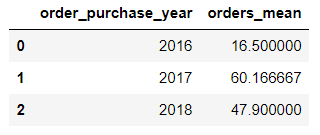

Список гипотетических причин отмены заказа:
1. Скорость доставки
2. Цена
3. Вес товара
4. Товар
5. Производитель
6. Пользователь 

Из них больше всего внимания на себя обратили product_id и seller_id

Для заказов со статусом unavailable предположительная причина - отсутствие товара на складе/отсутствие продавца

Также, был сделан вывод о том, что бОльшую часть заказов отменяют уже после оплаты (483 из 625)

Так же была рассчитана статистика  по месяцам для "опоздавших" заказов  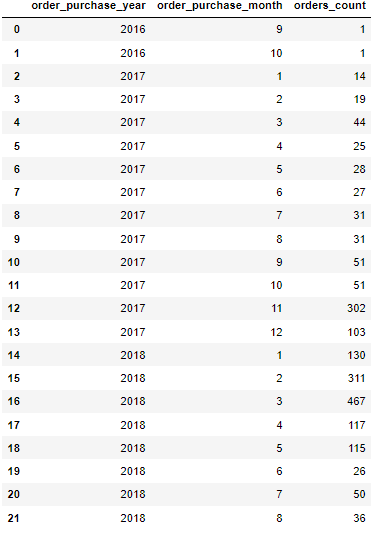

Опоздавших заказов больше (2202), чем по какой-то причине недоставленных (1316)

# В какой день недели каждый товар чаще всего покупается

In [296]:
orders_items.head()

,order_id,order_item_id,order_status,order_purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,order_purchase_year,customer_id,customer_city,customer_state,product_id,seller_id,shipping_limit_date,price,freight_value,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,10,2017,9ef432eb6251297304e76186b10a928d,franca,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,15
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,7,2018,b0830fb4747a6c6d20dea0b8c802d7ef,sao bernardo do campo,SP,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,19
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,8,2018,41ce2a54c0b03bf3443c3d931a367089,sao paulo,SP,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,26
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,11,2017,f88197465ea7920adcdbec7375364d82,mogi das cruzes,SP,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,26
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2,2018,8ab97904e6daea8866dbdbc4fb7aad2c,campinas,SP,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,12


In [388]:
df = orders_items[['product_id', 'order_approved_at','order_item_id','order_id']]
df
#На мой взгляд, тут корректнее будет смотреть на время оплаты заказа, причем для всех статусов, 
#кроме 'canceled' и 'unavailable'.
#Так как многие заказы находятся в стадии обработки/доставки + как мы выяснили в предыдущем задании, product_id 
#в подавляющем большинстве случаев вряд ли влияет на вероятность отмены заказа

,product_id,order_approved_at,order_item_id,order_id
0,87285b34884572647811a353c7ac498a,2017-10-02 11:07:15,1.0,e481f51cbdc54678b7cc49136f2d6af7
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-26 03:24:27,1.0,53cdb2fc8bc7dce0b6741e2150273451
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:55:23,1.0,47770eb9100c2d0c44946d9cf07ec65d
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:45:59,1.0,949d5b44dbf5de918fe9c16f97b45f8a
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 22:20:29,1.0,ad21c59c0840e6cb83a9ceb5573f8159
...,...,...,...,...
113420,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02-06 13:10:37,1.0,63943bddc261676b46f01ca7ac2f7bd8
113421,b80910977a37536adeddd63663f916ad,2017-08-27 15:04:16,1.0,83c1379a015df1e13d02aae0204711ab
113422,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:36:21,1.0,11c177c8e97725db2631073c19f07b62
113423,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:36:21,2.0,11c177c8e97725db2631073c19f07b62


In [389]:
df.isna().sum()  #Удалим строки с отсутствующими данными

product_id           775
order_approved_at    161
order_item_id        775
order_id               0
dtype: int64

In [390]:
df = df.dropna()

In [391]:
df['dow_purchase'] = df['order_approved_at'].dt.dayofweek

C:\Users\User\AppData\Local\Temp\ipykernel_6500\618927771.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [392]:
df.head() #Добавила колонку момента оплаты заказа по дням недели, где 0 - это понедельник, 6 - это воскресенье

,product_id,order_approved_at,order_item_id,order_id,dow_purchase
0,87285b34884572647811a353c7ac498a,2017-10-02 11:07:15,1.0,e481f51cbdc54678b7cc49136f2d6af7,0
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-26 03:24:27,1.0,53cdb2fc8bc7dce0b6741e2150273451,3
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:55:23,1.0,47770eb9100c2d0c44946d9cf07ec65d,2
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:45:59,1.0,949d5b44dbf5de918fe9c16f97b45f8a,5
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 22:20:29,1.0,ad21c59c0840e6cb83a9ceb5573f8159,1


In [393]:
df = df.groupby(['product_id','dow_purchase'], as_index = False)['order_id'].nunique().sort_values('order_id').rename(columns={'order_id':'order_count'})
#группируем данные по товарам и дням недели, теперь нужно найти дни, в которые товар чаще всего покупается

In [303]:
df.head()

,product_id,dow_purchase,order_id
61120,ffe8083298f95571b4a66bfbc1c05524,5,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,4,1
3,000b8f95fcb9e0096488278317764d19,2,1
4,000b8f95fcb9e0096488278317764d19,4,1


In [395]:
df['max_orders'] = df.groupby('product_id')['order_count'].transform(max)

C:\Users\User\AppData\Local\Temp\ipykernel_6500\2875645195.py:1: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



In [396]:
result = df[df['order_count'] == df['max_orders']]
result = result.drop('order_count', axis = 1)
result.head()
#Итоговая таблица с ответом на поставленный вопрос

,product_id,dow_purchase,max_orders
61120,ffe8083298f95571b4a66bfbc1c05524,5,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,4,1
3,000b8f95fcb9e0096488278317764d19,2,1
4,000b8f95fcb9e0096488278317764d19,4,1


# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

In [411]:
purchases = pd.read_csv('customers.csv')
orders = pd.read_csv('orders.csv')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [412]:
purchases = orders.merge(customers, how='left', on='customer_id')

In [413]:
purchases = purchases.query("order_status != 'canceled' and order_status != 'unavailable'")

In [414]:
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [415]:
purchases = purchases[['order_id','customer_unique_id','order_purchase_timestamp']]
#Здесь теперь также возьмём дату создания заказа, для всех заказов, кроме unavailable и canceled

In [416]:
purchases.isna().sum()

order_id                    0
customer_unique_id          0
order_purchase_timestamp    0
dtype: int64

In [417]:
purchases['month'] = purchases['order_purchase_timestamp'].dt.month
purchases['year'] = purchases['order_purchase_timestamp'].dt.year

In [418]:
purchases.head()

,order_id,customer_unique_id,order_purchase_timestamp,month,year
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,10,2017
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,7,2018
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,8,2018
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,11,2017
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2,2018


In [419]:
purchases['month'].astype('int64')

0        10
1         7
2         8
3        11
4         2
         ..
99436     3
99437     2
99438     8
99439     1
99440     3
Name: month, Length: 98207, dtype: int64

In [420]:
purchases.loc[purchases['month'].isin([1, 3, 5, 7, 8, 10, 12]), 'weeks'] = 4.43 #(31 день / 7)
purchases.loc[purchases['month'].isin([4, 6, 9, 11]), 'weeks'] = 4.28 #(30 дней / 7)
purchases.loc[purchases['month'].isin([2]), 'weeks'] = 4 #(28 дней / 7)
#Февраля високосного года (2016) в данных нет, поэтому его можно не учитывать

In [421]:
purchases.head()

,order_id,customer_unique_id,order_purchase_timestamp,month,year,weeks
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,10,2017,4.43
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,7,2018,4.43
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,8,2018,4.43
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,11,2017,4.28
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2,2018,4.00


In [422]:
purchases.order_purchase_timestamp.min()

Timestamp('2016-09-04 21:15:19')

In [423]:
purchases.order_purchase_timestamp.max()

Timestamp('2018-09-03 09:06:57')

In [425]:
orders_per_user = purchases.groupby(['year','month','weeks','customer_unique_id'], as_index = False)['order_id'] \
.nunique() \
.sort_values('order_id') \
.rename(columns={'order_id':'orders_count','customer_unique_id':'user_id'})

orders_per_user.tail(10)

,year,month,weeks,user_id,orders_count
42308,2017,12,4.43,b59e4bb4efe81ba0f7d30cff6734f9a2,3
55781,2018,2,4.00,ba87a137c5191264841e0be40e53f4ed,3
684,2017,1,4.43,83e7958a94bd7f74a9414d8782f87628,4
2094,2017,2,4.00,a239b8e2fbce33780f1f1912e2ee5275,4
5671,2017,4,4.28,25a560b9a6006157838aab1bdbd68624,4
25304,2017,9,4.28,b08fab27d47a1eb6deda07bfd965ad43,4
95490,2018,8,4.43,c8460e4251689ba205045f3ea17884a1,4
55636,2018,2,4.00,b4e4f24de1e8725b74e4a1f4975116ed,4
52637,2018,2,4.00,3e43e6105506432c953e165fb2acf44c,4
357,2017,1,4.43,12f5d6e1cbf93dafd9dcc19095df0b3d,6


In [426]:
orders_per_user['orders_per_week'] = orders_per_user['orders_count'] / orders_per_user['weeks']

In [483]:
orders_per_user.sort_values('orders_per_week').tail(10)

,year,month,weeks,user_id,orders_count,orders_per_week
55781,2018,2,4.00,ba87a137c5191264841e0be40e53f4ed,3,0.750000
56425,2018,2,4.00,d3882d7abd0c66064d740d7ed04dd1ef,3,0.750000
684,2017,1,4.43,83e7958a94bd7f74a9414d8782f87628,4,0.902935
95490,2018,8,4.43,c8460e4251689ba205045f3ea17884a1,4,0.902935
25304,2017,9,4.28,b08fab27d47a1eb6deda07bfd965ad43,4,0.934579
5671,2017,4,4.28,25a560b9a6006157838aab1bdbd68624,4,0.934579
52637,2018,2,4.00,3e43e6105506432c953e165fb2acf44c,4,1.000000
2094,2017,2,4.00,a239b8e2fbce33780f1f1912e2ee5275,4,1.000000
55636,2018,2,4.00,b4e4f24de1e8725b74e4a1f4975116ed,4,1.000000
357,2017,1,4.43,12f5d6e1cbf93dafd9dcc19095df0b3d,6,1.354402


Итоговая таблица. Практически все клиенты (кроме 4х) совершают менее одного заказа в неделю

# Когоротный анализ пользователей

1. Признак формирования когорты — действие, которое объединяет людей в группу: повторная покупка
2. Размер когорты — временной интервал: месяц
3. Отчетный период — с января по декабрь 2017 года
4. Retention Rate

In [429]:
table = pd.read_csv('orders.csv')
customers = pd.read_csv('customers.csv')
table = table.query("order_status != 'canceled' and order_status !='unavailable'") #убираем ненужные заказы
table = table.merge(customers, how='left', on='customer_id')

In [430]:
table = table[['customer_unique_id', 'order_approved_at']] #берём только нужные колонки
table['order_approved_at'] = pd.to_datetime(table['order_approved_at']) #преобразуем формат даты
table = table.dropna()

In [431]:
table['order_period'] = table.order_approved_at.apply(lambda x: x.strftime('%Y-%m'))
table.isna().sum()
table.rename(columns={'customer_unique_id':'user_id','order_period':'month' }, inplace = True)

In [432]:
first_order = table.groupby(['user_id'], as_index = False).agg({'order_approved_at':'min'}).rename(columns = {'order_approved_at':'first_order'})
first_order = first_order.query("first_order.dt.year == 2017")
first_order['first_order'] = first_order.first_order.apply(lambda x: x.strftime('%Y-%m'))
#Определяем, когда был первый заказ у пользователя

In [433]:
grouped = table.merge(first_order, how='left', on ='user_id').query('order_approved_at.dt.year == 2017')
#Оставляем данные только за 2017 год

In [434]:
cohorts = grouped.groupby(['first_order','month']) \
.agg({'user_id': pd.Series.nunique}) \
.rename(columns={'user_id':'user_count'})

cohorts

user_count
first_order month              
2017-01     2017-01         716
            2017-02           4
            2017-03           2
            2017-04           1
            2017-05           3
...                         ...
2017-10     2017-11          30
            2017-12          13
2017-11     2017-11        7053
            2017-12          39
2017-12     2017-12        5591

[77 rows x 1 columns]

In [435]:
def cohort_period(df):
	df['cohort_period'] = np.arange(len(df))
	return df 
cohorts = cohorts.groupby(level=0, as_index = False).apply(cohort_period)  #Группировка по first_order
cohorts

user_count  cohort_period
   first_order month                             
0  2017-01     2017-01         716              0
               2017-02           4              1
               2017-03           2              2
               2017-04           1              3
               2017-05           3              4
...                            ...            ...
9  2017-10     2017-11          30              1
               2017-12          13              2
10 2017-11     2017-11        7053              0
               2017-12          39              1
11 2017-12     2017-12        5591              0

[77 rows x 2 columns]

In [436]:
cohorts.reset_index(inplace = True)
cohorts.set_index(['cohort_period','first_order'], inplace=True) 
cohorts

,,level_0,month,user_count
cohort_period,first_order,,,
0,2017-01,0,2017-01,716
1,2017-01,0,2017-02,4
2,2017-01,0,2017-03,2
3,2017-01,0,2017-04,1
4,2017-01,0,2017-05,3
...,...,...,...,...
1,2017-10,9,2017-11,30
2,2017-10,9,2017-12,13
0,2017-11,10,2017-11,7053


In [437]:
cohort_group_size = cohorts['user_count'].groupby(level=1).first()
cohort_group_size

first_order
2017-01     716
2017-02    1674
2017-03    2580
2017-04    2301
2017-05    3543
2017-06    3110
2017-07    3776
2017-08    4154
2017-09    4097
2017-10    4360
2017-11    7053
2017-12    5591
Name: user_count, dtype: int64

In [438]:
cohorts

,,level_0,month,user_count
cohort_period,first_order,,,
0,2017-01,0,2017-01,716
1,2017-01,0,2017-02,4
2,2017-01,0,2017-03,2
3,2017-01,0,2017-04,1
4,2017-01,0,2017-05,3
...,...,...,...,...
1,2017-10,9,2017-11,30
2,2017-10,9,2017-12,13
0,2017-11,10,2017-11,7053


In [439]:
cohorts['retention'] = cohorts['user_count'] / cohort_group_size

In [440]:
cohorts = cohorts.reset_index().set_index(['first_order','cohort_period'])  

In [441]:
cohort_table = cohorts['retention'].unstack(1).head(15)

In [442]:
cohort_table

cohort_period,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-01,1.0,0.005587,0.002793,0.001397,0.004190,0.001397,0.004190,0.001397,0.001397,0.002793,0.002793
2017-02,1.0,0.002389,0.002389,0.001792,0.004182,0.001195,0.002389,0.001792,0.000597,0.001792,0.001195
2017-03,1.0,0.005039,0.003488,0.003488,0.003488,0.001550,0.001550,0.003101,0.003101,0.001163,NaN
2017-04,1.0,0.006084,0.002173,0.001738,0.002608,0.002608,0.003477,0.002608,0.003477,NaN,NaN
2017-05,1.0,0.005363,0.004798,0.003951,0.003105,0.003387,0.004234,0.001411,NaN,NaN,NaN
2017-06,1.0,0.004502,0.003537,0.003859,0.002572,0.003537,0.003537,NaN,NaN,NaN,NaN
2017-07,1.0,0.005297,0.003178,0.001854,0.003443,0.001854,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006740,0.003611,0.002648,0.003852,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006590,0.004882,0.003417,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [443]:
style_table = (cohort_table
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient('viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
style_table

cohort_period,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-01,100.00%,0.56%,0.28%,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,0.28%,0.28%
2017-02,100.00%,0.24%,0.24%,0.18%,0.42%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%
2017-03,100.00%,0.50%,0.35%,0.35%,0.35%,0.16%,0.16%,0.31%,0.31%,0.12%,
2017-04,100.00%,0.61%,0.22%,0.17%,0.26%,0.26%,0.35%,0.26%,0.35%,,
2017-05,100.00%,0.54%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.35%,0.35%,,,,
2017-07,100.00%,0.53%,0.32%,0.19%,0.34%,0.19%,,,,,
2017-08,100.00%,0.67%,0.36%,0.26%,0.39%,,,,,,
2017-09,100.00%,0.66%,0.49%,0.34%,,,,,,,


Если посмотреть на таблицу в целом, видно, что через 1 месяц возвращается наибольший процент юзеров, для всех случаев,  кроме когорты 2017-02

Дальше показатели разнятся сильнее, когорты с наилучшими показателями на долгой дистанции: 2017-05, 2017-06, 2017-08, в следующие месяцы в целом тоже неплохие показатели, но о них пока мало данных

Есть предположение, что примерно с 2017-04 магазин ввёл какое-то изменение, которое увеличило retention и он стал более стабильным, так как в первые 4 месяца 2017 года показатели были скачущими, самая неудачная когорта: 2017-02

В целом, можно сказать, что retention кажется очень низким, при самых удачных обстоятельствах 0,5-0,7%, возможно, это связано со спецификой товаров данного магазина

# RFM-анализ

In [450]:
df = pd.read_csv('orders.csv')
customers = pd.read_csv('customers.csv')
df['order_purchase_time'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df.query("order_purchase_time.dt.year == 2017 and order_status != 'canceled' and order_status != 'unavailable'") 
#Делаем RFM анализ за 2017 год

In [451]:
df = df.merge(customers, how='left', on='customer_id')

In [452]:
df.isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                 18
order_delivered_carrier_date     423
order_delivered_customer_date    953
order_estimated_delivery_date      0
order_purchase_time                0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
dtype: int64

In [453]:
df.shape

(44379, 13)

In [454]:
df.rename(columns={'customer_unique_id':'user_id'}, inplace=True)
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_time,user_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
2,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,2017-07-09 21:57:05,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR
3,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,2017-04-11 12:22:08,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS
4,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00,2017-05-16 13:10:30,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ


In [456]:
frequency = df.groupby('user_id', as_index = False)['order_id'].nunique().rename(columns={'order_id':'frequency'})
#Находим количество заказов пользователей за всё время
frequency.sort_values('frequency').tail(10)

,user_id,frequency
40889,f34cd7fd85a1f8baff886edf09567be3,4
27252,a239b8e2fbce33780f1f1912e2ee5275,4
29693,b08fab27d47a1eb6deda07bfd965ad43,4
39790,ec7f1811826ab04a27a92197bc40c888,4
4629,1b6c7548a2a1f9037c1fd3ddfed95f33,5
12108,47c1a3033b8b77b3ab6e109eb4d5fdf3,5
16941,6469f99c1f9dfae7733b25662e7f1782,5
37154,dc813062e0fc23409cd255f7f53c7074,5
3233,12f5d6e1cbf93dafd9dcc19095df0b3d,6
23707,8d50f5eadf50201ccdcedfb9e2ac8455,9


In [457]:
NOW = df.order_purchase_time.max() + timedelta(days=1) #Искусственно выбираем "текущую дату"

In [458]:
NOW

Timestamp('2018-01-01 23:29:31')

In [459]:
df['days_since_order'] = df['order_purchase_time'].apply(lambda x: (NOW - x).days)
#Ищем количество дней с покупки до текущей даты

In [460]:
rfm = df.groupby('user_id', as_index=False).agg({'days_since_order':'min'}).rename(columns = {'days_since_order':'recency'})
#Выбираем наименьшую разницу, чтобы узнать количество дней с последнего заказа

In [461]:
rfm = rfm.merge(frequency, on='user_id') 
rfm.head()
#Осталось посчитать monetary

,user_id,recency,frequency
0,0000f46a3911fa3c0805444483337064,297,1
1,0000f6ccb0745a6a4b88665a16c9f078,81,1
2,0004aac84e0df4da2b147fca70cf8255,48,1
3,0005e1862207bf6ccc02e4228effd9a0,302,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1


In [463]:
user_ids = orders.merge(customers, how = 'inner', on='customer_id')
user_ids = user_ids[['order_id','customer_unique_id']]

In [464]:
goods = items.groupby(['order_id','product_id', 'price'], as_index=False) \
.agg({'order_item_id':'count'}) \
.rename(columns = {'order_item_id':'items_count'})

#Считаем сколько штук конкретного товара было в каждом заказе

In [465]:
goods['total_price'] = goods['price'] * goods['items_count']
cost = goods.groupby('order_id', as_index  = False).agg({'total_price':'sum'})
#Узнаём стоимость каждого заказа

In [466]:
cost

,order_id,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


In [467]:
monetary = cost.merge(user_ids, how='left', on='order_id')
monetary.rename(columns={'customer_unique_id':'user_id'}, inplace = True)

In [468]:
monetary = monetary.groupby('user_id', as_index = False).agg({'total_price':'sum'}).rename(columns={'total_price':'monetary'}).sort_values('monetary')
#Узнаём стоимость всех покупок для каждого юзера
#Здесь больше user_id, чем в rfm, так как здесь пользователи не только за 2017 год

In [469]:
final = rfm.merge(monetary, on='user_id')

In [471]:
final.head()

,user_id,recency,frequency,monetary
0,0000f46a3911fa3c0805444483337064,297,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90


In [472]:
px.histogram(final, x='monetary')

In [473]:
final['monetary'].describe()

count    43031.000000
mean       144.187957
std        226.240784
min          2.290000
25%         48.900000
50%         89.900000
75%        159.000000
max      13440.000000
Name: monetary, dtype: float64

Баллы для monetary:

1 - <200

2 - 200-500

3 - 500-1000

4 - 1000-5000

5 - >5000

Предлагаю такие диапазоны, так как всё же у нас очень много пользователей, заказывающих менее чем на 1000 рублей, поэтому,  чтобы отслеживать их действия, удобнее будет их раздробить мельче, чем остальных

In [474]:
def m_score(x):
    if x >=5000 :
        return 5
    elif x >=1000 :
        return 4
    elif x >=500 :
        return 3
    elif x >=200 :
        return 2
    else:
        return 1

In [475]:
final['M'] = final['monetary'].apply(lambda x: m_score(x))

In [476]:
px.histogram(final, x='frequency')

#С таким количеством заказов на пользователя, не очень понято как ранжировать frequency, 
#как вариант, посчитать средемесячное количество заказов на пользователя, и ранжировать его. Я пока что пропущу этот момент

In [477]:
px.histogram(final, x='recency')

#В целом, мне кажется, для recency идея с квантилями работала неплохо, но для удобства можно ранжировать по месяцам

Баллы для recency:

1 - > 180 дней с последней покупки

2 - 90-180 дня с последней покупки

3 - 60-90 дней с последней покупки

4 - 30-60 дней с последней покупки

5 - менее 30 дней с последней покупки

In [478]:
def r_score(x):
    if x <= 30:
        return 5
    elif x <= 60:
        return 4
    elif x <= 90:
        return 3
    elif x <= 180:
        return 2
    else:
        return 1

In [479]:
final['R'] = final['recency'].apply(lambda x: r_score(x))

In [480]:
final

,user_id,recency,frequency,monetary,M,R
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,1,3
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,1,4
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,1,2
...,...,...,...,...,...,...
43026,fffbf87b7a1a6fa8b03f081c5f51a201,5,1,149.00,1,5
43027,fffcf5a5ff07b0908bd4e2dbc735a684,207,1,1570.00,4,1
43028,fffea47cd6d3cc0a88bd621562a9d061,22,1,64.89,1,5
43029,ffff371b4d645b6ecea244b27531430a,328,1,89.90,1,1


Не знаю, как поступить с frequency, мне кажется, что если считать её по месяцам, 
будет слишком большое нагромождение, вероятно, её здесь лучше не рассматривать и изучить эту метрику, 
например, с помощью когортного анализа

Не нашла сегментацию отдельно для monetary и recency, можно попробовать вот такую  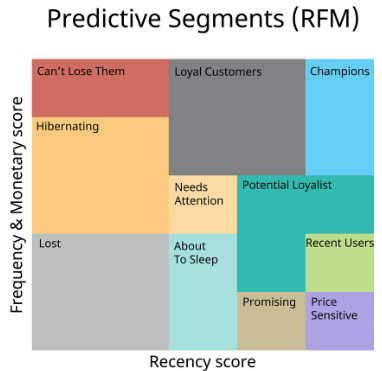

Но она,конечно, точно такая же, как и для frequency-recency

In [481]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

#Словарь для сегментации клиентов с помощью регулярных выражений
#В данной сегментации используются только recency и frequency, чтобы не создавать слишком много категорий

final['segment'] = final['R'].map(str) + final['M'].map(str)
final['segment'] = final['segment'].replace(segt_map, regex=True)
final.head()

,user_id,recency,frequency,monetary,M,R,segment
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,hibernating
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,1,3,about to sleep
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,1,4,promising
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1,hibernating
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,1,2,hibernating


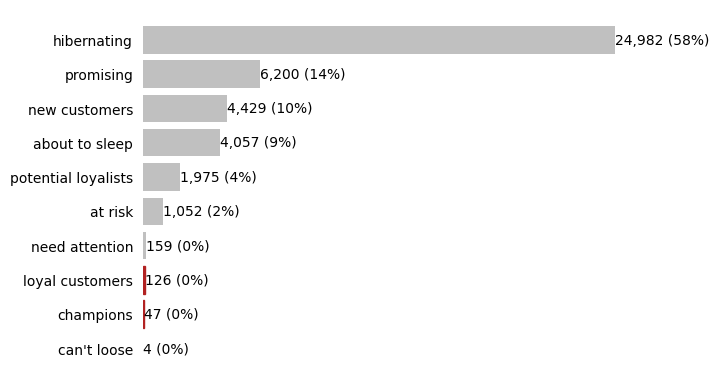

In [482]:
segments_counts = final['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

На графике видно, что больше половины клиентов совершали покупку более 6 месяцев назад на сумму менее 200 рублей. При этом, приток новых клиентов только 10% от общего количества. Нужно сделать упор на небольшое количество оставшихся клиентов и активнее работать над привлечением новых.